In [56]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import nolds
from sklearn.decomposition import PCA

In [40]:
def calc_feat(data):
    feat = []
    feat_nm = ['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag']
    
    ts = data['time(s)']
    x = data['x(g)']
    y = data['y(g)']
    z = data['z(g)']
    mag = (x**2+y**2+z**2)**.5
    
    feat.append(np.mean(x)), feat.append(np.mean(y)), feat.append(np.mean(z)), feat.append(np.mean(mag))
    feat.append(np.std(x)), feat.append(np.std(y)), feat.append(np.std(z)), feat.append(np.std(mag))
    feat.append(stats.skew(x)), feat.append(stats.skew(y)), feat.append(stats.skew(z)), feat.append(stats.skew(mag))
    feat.append(stats.kurtosis(x)), feat.append(stats.kurtosis(y)), feat.append(stats.kurtosis(z)), feat.append(stats.kurtosis(mag))
    
    feat.append(nolds.sampen(x[::5])), feat.append(nolds.sampen(y[::5])), feat.append(nolds.sampen(z[::5])), feat.append(nolds.sampen(mag[::5]))
    
    return pd.Series(data = feat, index = feat_nm)

In [54]:
def gen_clips(data, clipsize=60, overlap = .5):
    Features = pd.DataFrame(columns = ['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag'])
    ts = data['time(s)']
    tslen = max(ts)-min(ts)
    for ind in range(int((tslen-clipsize)/(clipsize*(1-overlap)))+1):
        start_ts = min(ts)+ind*(clipsize*(1-overlap))
        clipInds = (ts>=start_ts) & (ts<start_ts+clipsize)
        Features.loc[start_ts,:] = calc_feat(data[clipInds])
        
    return Features
        
    

In [58]:
D = pd.read_csv('C:\\Users\\nshawen\\Documents\\CP\\Normal\\dev3.txt',sep='\t')

In [59]:
# CP = gen_clips(D)
Normal = gen_clips(D)

In [60]:
pca = PCA()

In [63]:
P = pca.fit_transform(pd.concat((Normal,CP)))

In [69]:
I = pd.concat((Normal,CP)).index

In [70]:
c = ['b', 'r']
col = [c[int(x>3000)] for x in I]

In [71]:
col

['r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b']

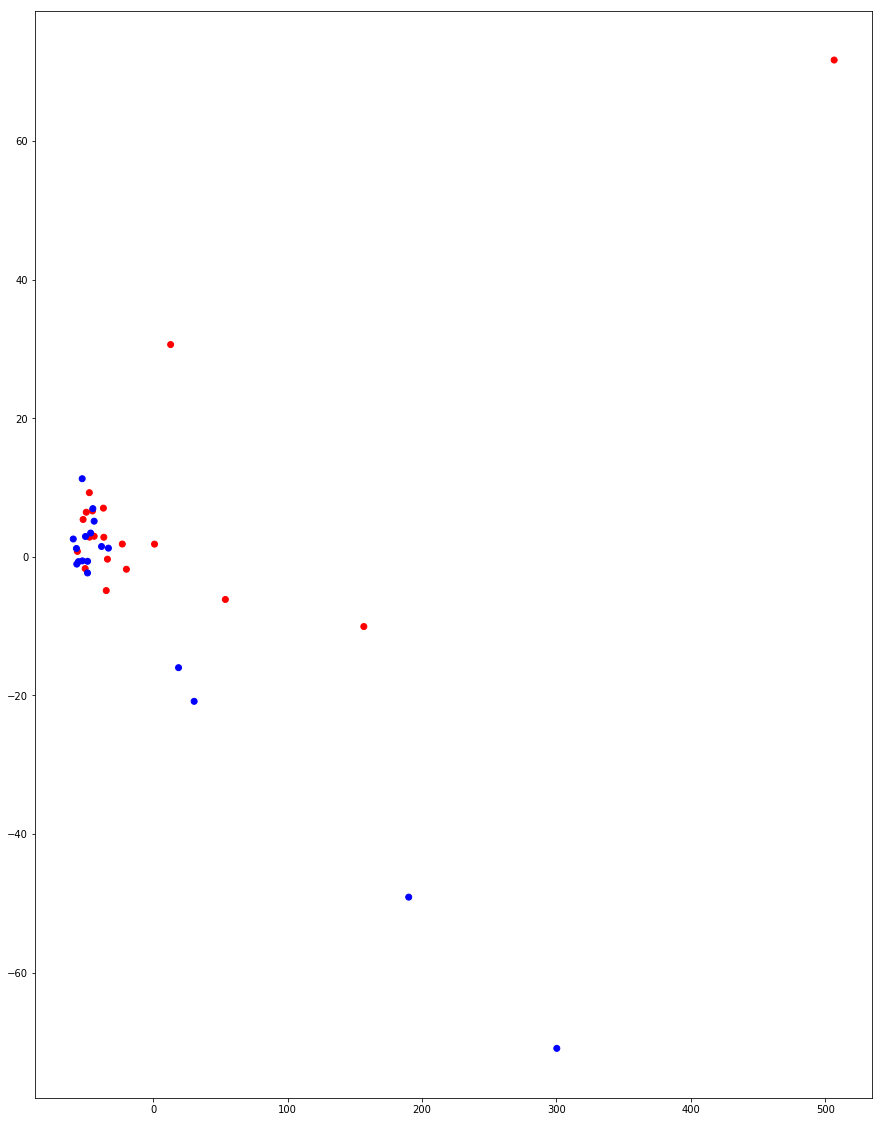

In [75]:
plt.figure(figsize=(15,20))
plt.scatter(P[:,0],P[:,1],c = col)

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


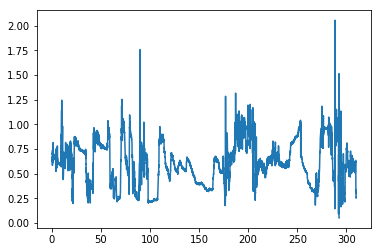

In [26]:
plt.plot(D['time(s)'],D.apply(lambda x: (x['x(g)']**2 + x['y(g)']**2 + x['z(g)'])**.5,axis=1)*0.0312)

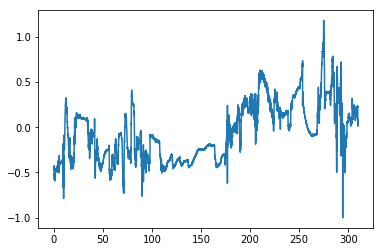

In [27]:
plt.plot(D['time(s)'],D['x(g)']*0.0312)

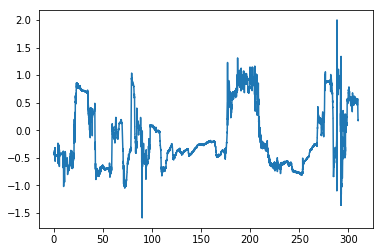

In [28]:
plt.plot(D['time(s)'],D['y(g)']*0.0312)

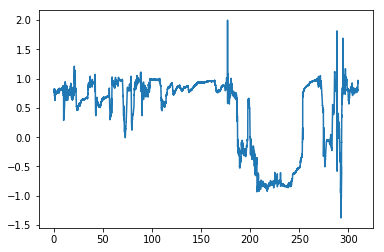

In [29]:
plt.plot(D['time(s)'],D['z(g)']*0.0312)